In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [2]:
# make a list of feature_names

feature_names = [
    'SepalLength',
    'SepalWidth',
    'PetalLength',
    'PetalWidth']

When we train our model, we'll need a function that reads the input file and returns the feature and label data. Estimators requires that you create a function of the following format:

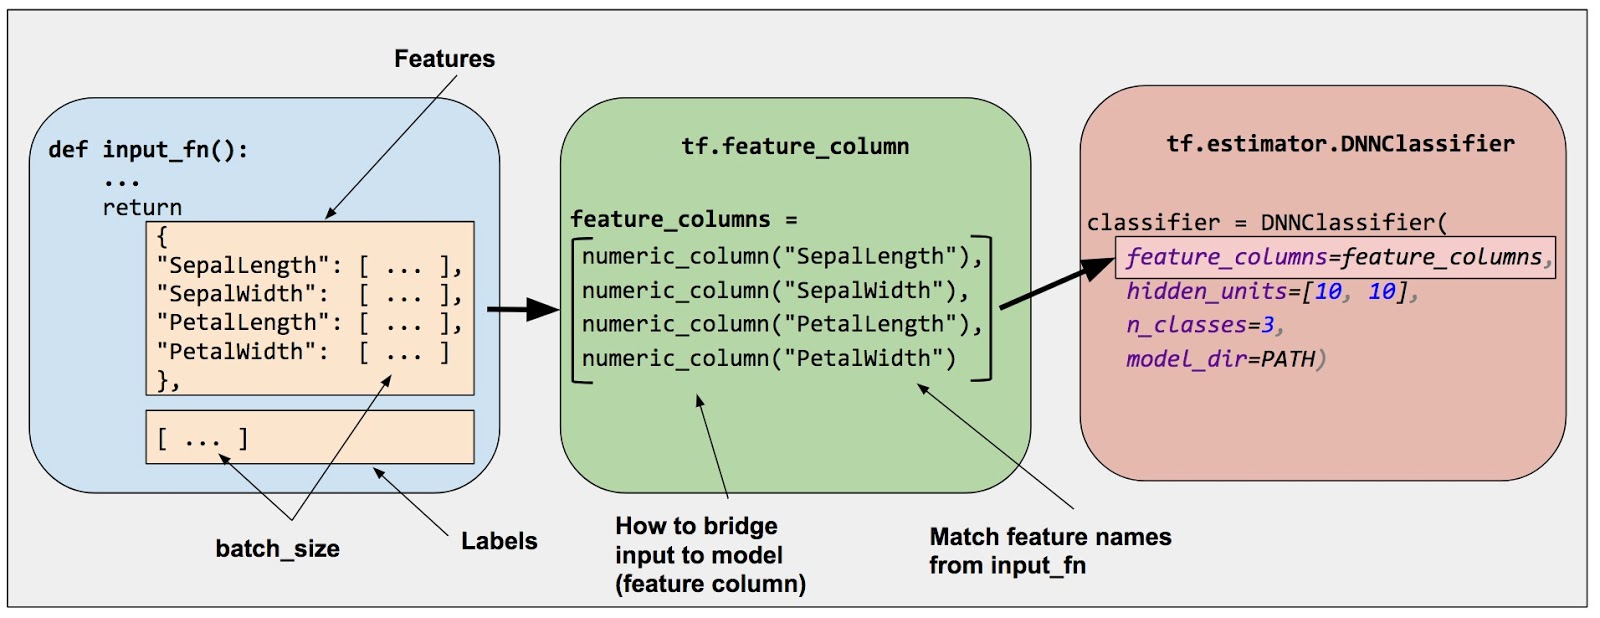

In [30]:
from IPython.display import Image
Image("modelPic.jpg",width=900,height=900)

The return value must be a two-element tuple organized as follows: :

The first element must be a dict in which each input feature is a key, and then a list of values for the training batch.
The second element is a list of labels for the training batch.
Since we are returning a batch of input features and training labels, it means that all lists in the return statement will have equal lengths. Technically speaking, whenever we referred to "list" here, we actually mean a 1-d TensorFlow tensor.

To allow simple reuse of the input_fn we're going to add some arguments to it. This allows us to build input functions with different settings. The arguments are pretty straightforward:

1. file_path: The data file to read.
2. perform_shuffle: Whether the record order should be randomized.
3. repeat_count: The number of times to iterate over the records in the dataset. For example, if we specify 1, then each record is read once. If we specify None, iteration will continue forever.

Here's how we can implement this function using the Dataset API. We will wrap this in an "input function" that is suitable when feeding our Estimator model later on:

In [3]:
def my_input_func(file_path,perform_shuffle = False,repeat_count = 1):
    
    def decode_csv(line):
        parsed_line = tf.decode_csv(records=line,record_defaults=[[0.],[0.],[0.],[0.],[0]])  #Convert CSV records to tensors. 
                                                                    #    Each column maps to one tensor.        
        label = parsed_line[-1]                                      ## Last element is the label
        del parsed_line[-1]                                         # delete last element
        
        features = parsed_line                                       # everything but the last element are the features
        
        d = dict(zip(feature_names,features)),label    # this is creating a tuple with first element as (dictionary of feature_name
        return d                                              # and feature values) n labels
        
        #The return value must be a two-element tuple organized as follows: :
#        1. The first element must be a dict in which each input feature is a key, and then a list of values for the training batch.
#        2. The second element is a list of labels for the training batch.
    
    def _input_func():
        dataset = tf.data.TextLineDataset([file_path]).skip(1).map(decode_csv)  # skip header row n map to above funcn
        
        if perform_shuffle:
            dataset = dataset.shuffle(buffer_size = 256)
        
        dataset = dataset.repeat(repeat_count)                                            # Repeats dataset this # times
        dataset = dataset.batch(32)                                                            # Batch size to use
        iterator = dataset.make_one_shot_iterator()
        batch_features, batch_labels = iterator.get_next()
        return batch_features,batch_labels
        
    return _input_func      


# we could have writeen the second_code without wrapping around an empty func. However, DNN classifier takes object of an empty
# function class, which should return features and labels. so instead of creating lamda function every_time, we can just
# create a function here.

### Let's see what our my_input_func is doing

In [31]:
next_batch = my_input_func(r"C:\Users\Urvashi\Desktop\New folder\Urvashi\Datasets\Iris_2.csv")


with tf.Session(graph=tf.get_default_graph()) as s:
    first_batch = s.run(next_batch)
    print(first_batch)
    
# so it is creating a tuple of dictionary of feature_name : feature_labels

RuntimeError: The Session graph is empty.  Add operations to the graph before calling run().

### Introducing Estimators

Estimators is a high-level API that reduces much of the boilerplate code you previously needed to write when training a TensorFlow model. Estimators are also very flexible, allowing you to override the default behavior if you have specific requirements for your model.

There are two possible ways you can build your model using Estimators:

1. Pre-made Estimator - These are predefined estimators, created to generate a specific type of model. In this blog post, we will use the DNNClassifier pre-made estimator.

2. Estimator (base class) - Gives you complete control of how your model should be created by using a model_fn function. We will cover how to do this in a separate blog post.

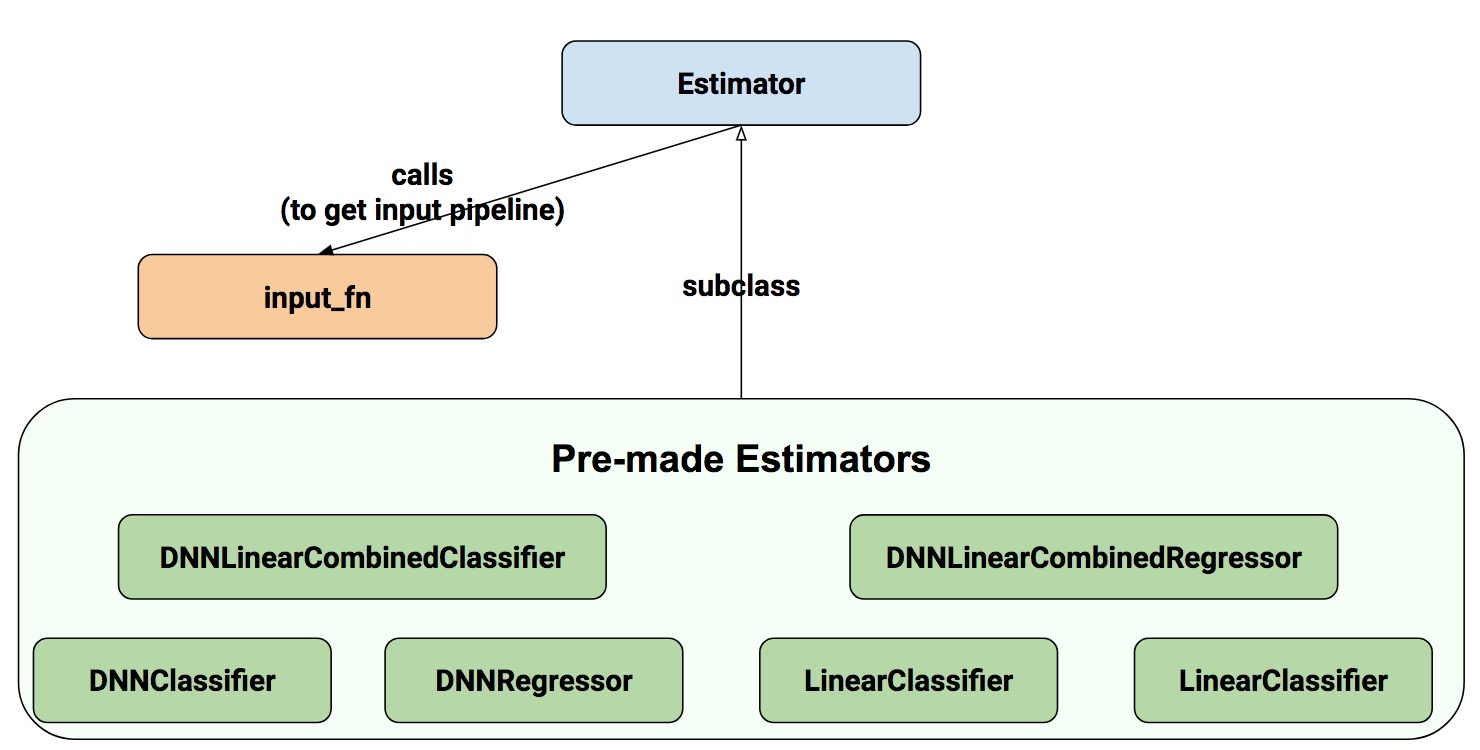

In [5]:
from IPython.display import Image
Image("estimator.jpg",width=700,height=700)

As you can see, all estimators make use of input_fn that provides the estimator with input data. In our case, we will reuse my_input_fn, which we defined for this purpose.

The following code instantiates the estimator that predicts the Iris flower type:

In [6]:
# Create the feature_columns, which specifies the input to our model.
# All our input features are numeric, so use numeric_column for each one.

feature_cols = [tf.feature_column.numeric_column(k) for k in feature_names]

In [33]:
tf.feature_column.categorical_column_with_identity(key="Type",num_buckets=3)

_IdentityCategoricalColumn(key='Type', num_buckets=3, default_value=None)

In [25]:
# Create a deep neural network regression classifier.
# Use the DNNClassifier pre-made estimator

classifier = tf.estimator.DNNClassifier(feature_columns=feature_cols,
                                        hidden_units=[10,10],
                                        n_classes = 3,
                                        model_dir = "../model/IrisDNN/")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '../model/IrisDNN/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000015A554479B0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


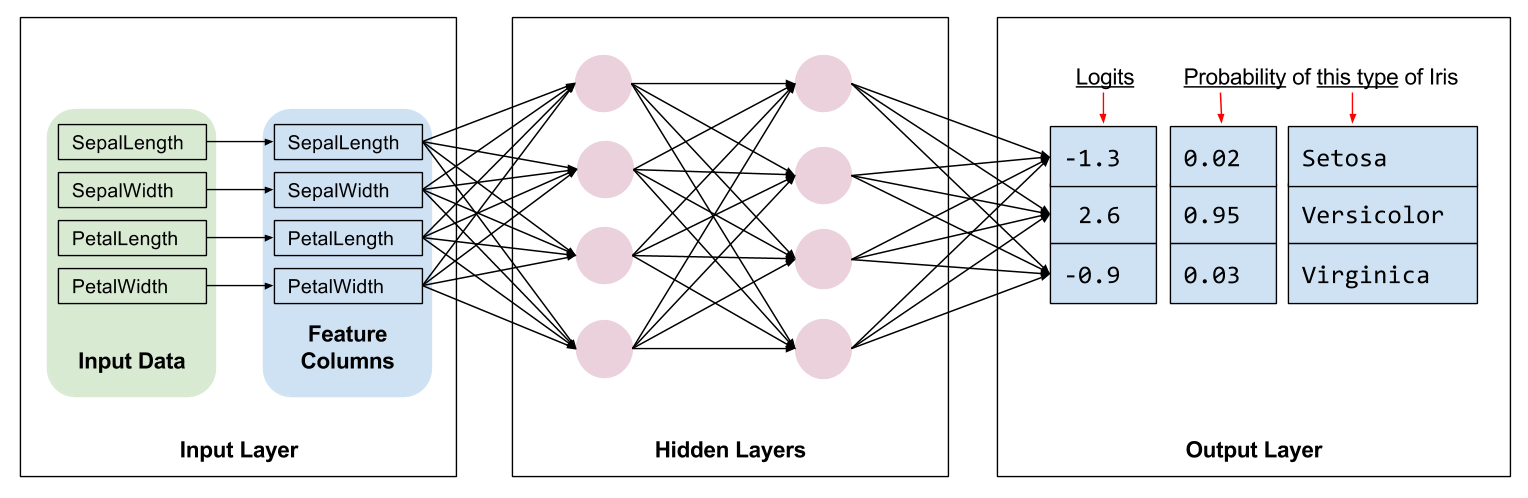

In [28]:
from IPython.display import Image
Image("full_network.png")

We now have a estimator that we can start to train.

### Training the model
Training is performed using a single line of TensorFlow code:

In [27]:
estimator = classifier.train(input_fn= my_input_func(file_path="iris_train2.csv",perform_shuffle=True,repeat_count=8),
                             steps=4000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ../model/IrisDNN/model.ckpt.
INFO:tensorflow:loss = 70.3064, step = 1
INFO:tensorflow:Saving checkpoints for 30 into ../model/IrisDNN/model.ckpt.
INFO:tensorflow:Loss for final step: 9.20872.


In [17]:
help(tf.estimator.DNNClassifier)

Help on class DNNClassifier in module tensorflow.python.estimator.canned.dnn:

class DNNClassifier(tensorflow.python.estimator.estimator.Estimator)
 |  A classifier for TensorFlow DNN models.
 |  
 |  Example:
 |  
 |  ```python
 |  categorical_feature_a = categorical_column_with_hash_bucket(...)
 |  categorical_feature_b = categorical_column_with_hash_bucket(...)
 |  
 |  categorical_feature_a_emb = embedding_column(
 |      categorical_column=categorical_feature_a, ...)
 |  categorical_feature_b_emb = embedding_column(
 |      categorical_column=categorical_feature_b, ...)
 |  
 |  estimator = DNNClassifier(
 |      feature_columns=[categorical_feature_a_emb, categorical_feature_b_emb],
 |      hidden_units=[1024, 512, 256])
 |  
 |  # Or estimator using the ProximalAdagradOptimizer optimizer with
 |  # regularization.
 |  estimator = DNNClassifier(
 |      feature_columns=[categorical_feature_a_emb, categorical_feature_b_emb],
 |      hidden_units=[1024, 512, 256],
 |      optimizer

But wait a minute... what is this "lambda: my_input_fn(FILE_TRAIN, True, 8)" stuff? That is where we hook up Datasets with the Estimators! Estimators needs data to perform training, evaluation, and prediction, and it uses the input_fn to fetch the data.

Estimators require an input_fn with no arguments, so we create a function with no arguments using lambda, which calls our input_fn with the desired arguments: the file_path, shuffle setting, and repeat_count. In our case, we use our my_input_fn, passing it:

FILE_TRAIN, which is the training data file.
True, which tells the Estimator to shuffle the data.
8, which tells the Estimator to and repeat the dataset 8 times

### Evaluating Our Trained Model

Ok, so now we have a trained model. How can we evaluate how well it's performing? 

Fortunately, every Estimator contains an evaluate method:

In [18]:
# Evaluate our model using the examples contained in FILE_TEST
# Return value will contain evaluation_metrics such as: loss & average_loss

evaluate_result = estimator.evaluate(input_fn=my_input_func("iris_test2.csv",False,4))

print("Evaluation Result")
print()
for key in evaluate_result:
     print("{} :{}".format(key,evaluate_result[key]))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-30-16:21:15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../model/IrisDNN/model.ckpt-30
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-06-30-16:21:16
INFO:tensorflow:Saving dict for global step 30: accuracy = 1.0, average_loss = 0.360953, global_step = 30, loss = 10.8286
Evaluation Result

accuracy :1.0
average_loss :0.3609534502029419
loss :10.828603744506836
global_step :30


### Making Predictions Using Our Trained Model

And that's it! We now have a trained model, and if we are happy with the evaluation results, we can use it to predict an Iris flower based on some input. As with training, and evaluation, we make predictions using a single function call:

In [19]:
predict_results = classifier.predict(input_fn=my_input_func("iris_test2.csv"))

print("Predictions on Test File")

for prediction in predict_results:
    print(prediction['class_ids'][0])

Predictions on Test File
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../model/IrisDNN/model.ckpt-30
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
1
1
1
2
2
2
1
0
0
2
0
1
1
1
1
2
1
0
0
0
1
0
0
1
0
1
2
2
1
2


### Making Predictions on Data in Memory

In [20]:
# Let create a memory dataset for prediction.
# We've taken the 6th,7th and 8th example in iris_test2.

prediction_input = [[6.9, 3.2, 5.7, 2.3],  # -> 2, Iris  Virginica
                    [5.4, 3,4.5, 1.5],  # -> 1, Iris Versicolor
                    [5.1, 3.8, 1.5, 0.3]]  # -> 0, Iris Sentosa

def new_input_fn():
    def decode(x):
        
        x = tf.split(x, 4) # Need to split into our 4 features
       # When predicting, we don't need (or have) any labels
        return dict(zip(feature_names, x)) # Then build a dict from them

   # The from_tensor_slices function will use a memory structure as input
    dataset = tf.data.Dataset.from_tensor_slices(prediction_input)
    dataset = dataset.map(decode)
    iterator = dataset.make_one_shot_iterator()
    next_feature_batch = iterator.get_next()
    return next_feature_batch, None # In prediction, we have no labels

# Predict all our prediction_input
predict_results = classifier.predict(input_fn=new_input_fn)

# Print results
print("Predictions on memory data")
print()
for idx, prediction in enumerate(predict_results):
    type = prediction["class_ids"][0] # Get the predicted class (index)
    if type == 0:
        print("I think: {}, is Iris Sentosa".format(prediction_input[idx]))
    elif type == 1:
        print("I think: {}, is Iris Versicolor".format(prediction_input[idx]))
    else:
        print("I think: {}, is Iris Virginica".format(prediction_input[idx]))

Predictions on memory data

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../model/IrisDNN/model.ckpt-30
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
I think: [6.9, 3.2, 5.7, 2.3], is Iris Virginica
I think: [5.4, 3, 4.5, 1.5], is Iris Versicolor
I think: [5.1, 3.8, 1.5, 0.3], is Iris Sentosa


To see this reporting, start TensorBoard from your command-line as follows: